In [2]:
import sys
!{sys.executable} -m pip install plotly

In [45]:
import sys
!{sys.executable} -m pip install numpy==1.20.0

     |████████████████████████████████| 15.3 MB 25.4 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap

In [4]:
from sklearn.manifold import TSNE

In [5]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext

import time 
from time import sleep

sc = SparkContext()
sc

<SparkContext master=yarn appName=pyspark-shell>

In [6]:
spark = SparkSession \
 .builder \
 .appName("Python Spark SQL basic example") \
 .config("spark.some.config.option", "some-value") \
 .getOrCreate()

In [7]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType,ArrayType

#### Read in Embedding

In [14]:
result = spark.read.parquet('s3://hids511final/corid_embedding_pca_200.parquet')

In [16]:
sample_seed_1 = result[['_c0','EMBEDDING','pca_features']].sample(.01,1)

In [17]:
sample_seed_1.count()

5615

In [49]:
sample_seed_1.write.parquet("s3://hids511final/corid_embedding_pca_200_sample_seed_01_1.parquet")

In [59]:
sample_seed_1.show()

KeyboardInterrupt: 

In [53]:
spark.read.parquet("s3://hids511final/corid_embedding_pca_200_sample_seed_01_1.parquet").show()

+--------+--------------------+--------------------+
|     _c0|           EMBEDDING|        pca_features|
+--------+--------------------+--------------------+
|ea73i30h|[1.83161938190460...|[-23.369895478398...|
|rdg40cgn|[0.27401238679885...|[33.1361619711654...|
|n5qmviz8|[4.12264442443847...|[-19.203451972680...|
|1deet5mv|[-2.7081129550933...|[-24.271692974872...|
|mvdey5k7|[-1.1477751731872...|[43.1629132400576...|
|kqvvr9g0|[-6.2017955780029...|[32.6409324074905...|
|imj8tfm4|[-5.2488799095153...|[46.9745451120642...|
|erh8ggh3|[1.25825905799865...|[-17.363647125235...|
|rrx3ig07|[-1.6100561618804...|[-36.021750269354...|
|aua7i3j9|[-3.4829342365264...|[34.4728687065263...|
|bxh7np1k|[0.56466686725616...|[-23.346976427268...|
|yp0j81jc|[0.88962012529373...|[-16.419438609103...|
|lpu6rax9|[-1.3084650039672...|[34.8754198246981...|
|0zkc5w74|[-0.5182961225509...|[-25.368733403557...|
|f0vlvpst|[2.88181734085083...|[-25.858292882598...|
|8eclfq9k|[-1.1383602619171...|[36.23156985879

In [20]:
df = pd.DataFrame(sample_seed_1[['_c0','EMBEDDING']].collect())

In [28]:
X = [np.array(i) for i in df[1].values]

#### TSNE

In [29]:
X_embedded = TSNE(n_components=2).fit_transform(X)

In [30]:
X_embedded.shape

(5615, 2)

#### Plot

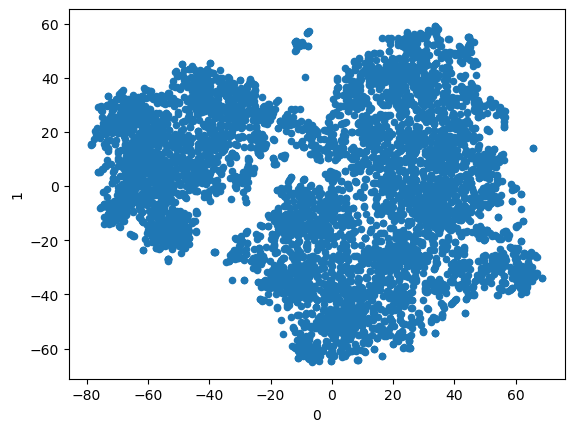

In [35]:
pd.DataFrame(X_embedded).plot.scatter(x=0,y=1)
plt.show()
plt.close()

In [ ]:
ax1 = df.plot.scatter(x='length',
                      y='width',
                      c='DarkBlue')

####  UMAP

In [54]:

umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(X)

In [55]:
umap_embeddings.shape

(5615, 5)

In [57]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=20,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

In [48]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(X_embedded)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')

NameError: name 'cluster' is not defined

In [135]:
sc.stop()

In [136]:
spark.stop()